In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

import sys
if '../' not in sys.path:
    sys.path.append('../')

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

import networkx as nx
import numpy as np
import argparse
import joblib
import os

from analysis import Evaluation
from dynamics import SISDynamicalSystem
import helpers

Construct the adjacency  matrix of the propagation network

In [8]:
net = nx.read_edgelist('../data/contiguous-usa.txt')
A = nx.adjacency_matrix(net).toarray().astype(float)

n_nodes = net.number_of_nodes()
n_edges = net.number_of_edges()
print(f"Network: {n_nodes:d} nodes, {n_edges:d} edges")
print()

# Initial infections
print('Choose set of initial infected seeds')
infected = 10
X_init = np.hstack(((np.ones(infected), np.zeros(n_nodes - infected))))
X_init = np.random.permutation(X_init)

print()

Network: 49 nodes, 107 edges

Choose set of initial infected seeds



In [45]:
sim_dict = {
    'total_time': 10.00,
    'trials_per_setting': 5
}
param_dict = {
    'beta':  6.0,
    'gamma': 5.0,
    'delta': 1.0,
    'rho':   5.0,
    'eta':   1.0
}
cost_dict = {
    'Qlam': 1.0,
    'Qx': 400.0
}
policy_list = [
    'SOC',
]
baselines_dict = {
    'TR': 0.003,
    'MN': 0.0007,
    'LN': 0.0008,
    'LRSR': 22.807,
    'MCM': 22.807,
    'FL_info': {'N': None, 'max_u': None},
}

In [46]:
def get_x_values(system, tspace):
    hf = helpers.HelperFunc()
    # Extract the values of the stochastic processes at all times
    x_values = np.zeros(len(tspace))
    for k, t in enumerate(tspace):
        x_values[k] = hf.sps_values(system.X, t, summed=True)
    return x_values

In [55]:
from collections import defaultdict

n_trials = 10

policy_list = [
    'SOC', 
#     'MN', 'LN', 'TR', 'TR-FL', 'MN-FL', 'LN-FL'
]

tspace = np.arange(0.0, 10.0, 0.01)
result = defaultdict(list)
for policy in policy_list:
    for i in range(n_trials):
        print(f"{policy} - trial {i+1}/{n_trials}")
        
        system = SISDynamicalSystem(X_init, A, param_dict, cost_dict, verbose=False, notebook=False)
        data = system.simulate_policy(policy, baselines_dict, sim_dict, plot=False)

        if policy == 'SOC':
            # Extract the maximum value of the control intensity
            max_u = max([max([proc.value_at(t) for t in proc.arrival_times]) for proc in data['u']])
            # Extract the number of treatements
            n_treatement = sum([proc.get_current_value() for proc in data['Nc']])
            if baselines_dict['FL_info']['N'] is None:
                baselines_dict['FL_info']['max_u'] = max_u
                baselines_dict['FL_info']['N'] = n_treatement
            elif n_treatement > baselines_dict['FL_info']['N']:
                baselines_dict['FL_info']['max_u'] = max_u
                baselines_dict['FL_info']['N'] = n_treatement
        
        x_values = get_x_values(system, tspace)
        result[policy].append(x_values)

SOC - trial 1/10
SOC - trial 2/10
SOC - trial 3/10
SOC - trial 4/10
SOC - trial 5/10
SOC - trial 6/10
SOC - trial 7/10
SOC - trial 8/10
SOC - trial 9/10
SOC - trial 10/10


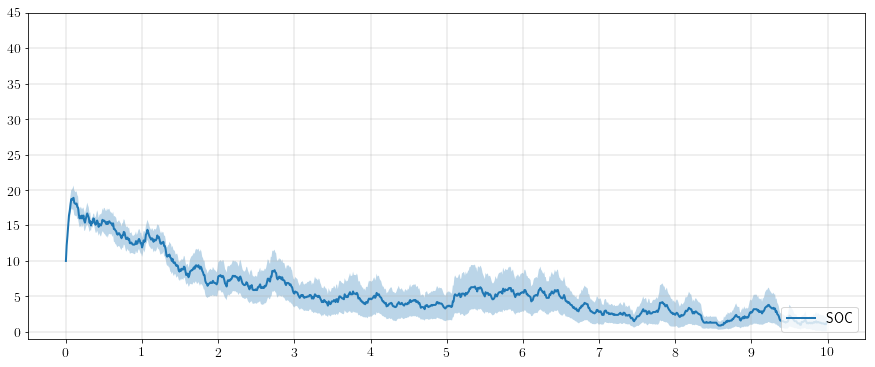

In [56]:
plt.figure(figsize=(15,6))
plt.grid()
for policy, x_values_list in result.items():
    x_values_arr = np.array(x_values_list)
    x_mean = np.mean(x_values_arr, axis=0)
    x_std = np.std(x_values_arr, axis=0) / np.sqrt(x_values_arr.shape[0])
    plt.fill_between(tspace, x_mean-x_std, x_mean+x_std, alpha=0.3)
    plt.plot(tspace, x_mean, label=policy)
plt.xticks(np.arange(0,tspace[-1]+1.0,1.0))
plt.yticks(range(0,50,5))
plt.legend(loc='lower right');